# Add Folders to Path

In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add FastTensorlineComputation folder to current working path
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FastTensorlineComputation")

Wall time: 0 ns


# Overview

In the following notebok we visualize hyperbolic OECS in the Agulhas region from the AVISO dataset using Fast Tensorline Computation. The notebook is structured as follows:

1. Import data from the file 'AVISO.mat' stored in the folder 'data'
<br />
2. Define computational parameters (such as the number of cores) and data
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from the (discrete) gridded data
 <br />
5. Hyperbolic OECS:

    * Compute rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $ using an auxiliary meshgrid. 
   
    * Compute eigenvectors $ \mathbf{e}_i $ of the rate of strain tensor $ \mathbf{S}(\mathbf{x}, t) $.
    
    * Hyperbolic OECS at time $ t $ are given by tensorlines starting from local maxima of $ s_2(x, y) $ which satisfy:
    
    \begin{equation}
    S \mathbf{e}_i = s_i \mathbf{e}_i
    \label{eq: tensorlines}
    \end{equation}
    
    $ \mathbf{e}_i $ denotes the eigenvector associated to the eigenvalue $ s_i $ of the rate of strain tensor $ S = S(\mathbf{x},t) $.
    The vector orthogonal to $ \mathbf{e}_i $ is denoted as $ \mathbf{e}_k $ and corresponds to the eigenvector associated to
    the eigenvalue $ s_k $ of $ S = S(\mathbf{x},t) $.
    
    The eigenvector field is a non-orientable vector field. Hence, computation of the tensorlines require constant checking of the orientation of the eigenvector before performing the integration step. The integration has thus to be done manually and one cannot rely on an automatic ODE solver. The following method highlights a way to compute the tensorlines of $ \mathbf{S} $ without having the deal with the orientational discontinuities of the eigenvector field
    
    Tensorlines are parametrized curves $ \mathbf{x}(s) $ such that: 
    
    \begin{equation}
    \dfrac{d}{ds}\mathbf{x} = \mathbf{e}_i(\phi(s))
    =\begin{pmatrix} \cos(\phi(s)) \\ \sin(\phi(s)) \end{pmatrix}.
    \end{equation}
    Taking the derivative of \ref{eq: tensorlines} with
    respect to $ s $ leads to:
    
    \begin{align}
    (\nabla_x S \mathbf{e}_i)\mathbf{e}_i + S\mathbf{e}_k\phi' &= \langle \nabla_x s_i, \mathbf{e}_i \rangle I \mathbf{e}_i +
    s_i\mathbf{e}_k\phi' \\
    (S\mathbf{e}_k-s_i\mathbf{e}_k)\phi' &= (\langle \nabla_x s_i, \mathbf{e}_i \rangle I - (\nabla_x S \mathbf{e}_i))
    \mathbf{e}_i
    \end{align}

    Multiplying the above equation from the left with $ \mathbf{e}_k^T $ leads to:

    \begin{align}
            \mathbf{e}_k^T (S\mathbf{e}_k-s_i\mathbf{e}_k) \phi' &= \mathbf{e}_k^T(\langle \nabla_x s_i, \mathbf{e}_i \rangle I - (\nabla_x S \mathbf{e}_i)) \mathbf{e}_i \\
    (s_k-s_i) \phi' &= -\mathbf{e}_k^T(\nabla_x S \mathbf{e}_i) \mathbf{e}_i
    \end{align}
    
    where we used the property $ S\mathbf{e}_k = \lambda_k \mathbf{e}_k $ and $ \langle \mathbf{e}_i, \dfrac{d}{ds}\mathbf{e}_i
    \rangle = \langle \mathbf{e}_i, \mathbf{e}_k \rangle = 0 $ for an incompressible flow. Assuming again incompressibility $
    s_i = -s_k $ it eventually holds:

    \begin{equation}
    \phi' = -\dfrac{1}{2s_k}\mathbf{e}_k^T(\nabla_x S \mathbf{e}_i) \mathbf{e}_i
    \end{equation}

    For repelling OECS, the tensorlines satisfy the ODEs:

    \begin{align}
    x'(s) &= \cos(\phi(s)) \\
    y'(s) &= \sin(\phi(s)) \\
    \phi'(s) &= -\dfrac{1}{2s_2}\mathbf{e}_2^T(\nabla_x S \mathbf{e}_1) \mathbf{e}_1
    \end{align}

    For attracting OECS, the tensorlines satisfy the ODEs:

    \begin{align}
    x'(s) &= \cos(\phi(s)) \\
    y'(s) &= \sin(\phi(s)) \\
    \phi'(s) &= -\dfrac{1}{2s_1}\mathbf{e}_1^T(\nabla_x S \mathbf{e}_2) \mathbf{e}_2
    \end{align}    

# Import Agulhas Data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/Aviso/AVISO.mat')

U = mat_file['u']
V = mat_file['v']
x = mat_file['x']
y = mat_file['y']
time_data = mat_file['t']

Wall time: 109 ms


# Data/Parameters for Dynamical System

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 8

# time resolution of data
dt_data = time_data[0, 1]-time_data[0,0]

# periodic boundary conditions
periodic_x = False
periodic_y = False
periodic = [periodic_x, periodic_y]

# unsteady velocity field
bool_unsteady = True

# defined domain
# This array denotes where the velocity field is defined (=1) and where it is not defined (=0)
defined_domain = np.isfinite(U[:,:,0]).astype(int)

## meshgrid
X, Y = np.meshgrid(x, y)

## resolution of meshgrid
dx_data = X[0,1]-X[0,0]
dy_data = Y[1,0]-Y[0,0]

delta = [dx_data, dy_data]

# Spatio-Temporal domain

In [4]:
%%time
# Time
t_OECS = 0

# store time in array
time = np.array([t_OECS])

# domain boundary (in degrees)
xmin = -3
xmax = 1
ymin = -32
ymax = -24

# make sure that domain is in the data
assert (xmax <= np.max(X) and xmin >= np.min(X) and ymin >= np.min(Y) and ymax <= np.max(Y) and np.min(time_data) <= t_OECS <= np.max(time_data)),"The domains you are chooising are outside the domain of the data!!!!! --> redefine spatial/temporal domain"
# spacing of meshgrid (in degrees)
dx = 0.02
dy = 0.02

x_domain = np.arange(xmin, xmax + dx, dx)
y_domain = np.arange(ymin, ymax + dy, dy)

X_domain, Y_domain = np.meshgrid(x_domain, y_domain)

Wall time: 998 µs


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". In order to favour a smooth velocity field, we interpolate the velocity field in space using a cubic interpolant.

In [5]:
%%time
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# set nan values to zero so that we can apply interpolant. Interpolant does not work if the array contains nan values
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, U, V, time_data, method = "cubic")

Wall time: 86.7 ms


# Rate of strain tensor over meshgrid of initial conditions

The rate of strain tensor $ S(\mathbf{x}, t) $ at time $ t $ is computed by iterating over meshgrid. The rate of strain tensor at point $ \mathbf{x} $ at time $ t $ is computed from the gradient of the velocity field by using an auxiliary meshgrid. 'aux_grid' specifies the ratio between the auxiliary grid and the original meshgrid. This parameter is generally chosen to be between $ [\dfrac{1}{10}, \dfrac{1}{100}] $. The computations are parallelized.

In [6]:
%%time
# Import package for progress bar
from tqdm.notebook import tqdm

# Import package for parallel computing
from joblib import Parallel, delayed

# Import gradient of velocity function
from ipynb.fs.defs.gradient_velocity import gradient_velocity

# Import package which checks particle location
from ipynb.fs.defs.check_location import check_location

# Import Rate of Strain function
from ipynb.fs.defs.RateStrain import RateStrain

# Import eigenvalue/eigenvector calculator
from ipynb.fs.defs.eigen import eigen

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # [1/10, 1/100]
aux_grid = [aux_grid_ratio*(X_domain[0, 1]-X_domain[0, 0]), aux_grid_ratio*(Y_domain[1, 0]-Y_domain[0, 0])]

def parallel_S(i):
    
    S_parallel = np.zeros((X_domain.shape[1], 2, 2))*np.nan
    
    for j in range(S_parallel.shape[0]):
        
        x = np.array([X_domain[i,j], Y_domain[i,j]])
        
        # only compute rate of Strain for trajectories starting region where velocity field is defined
        if check_location(X, Y, defined_domain, x)[0] == "IN":
        
            # Compute gradient of velocity
            grad_vel = gradient_velocity(t_OECS, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta, aux_grid)
        
            # Compute rate of strain at 'x'
            S_parallel[j, :, :] = RateStrain(grad_vel)
    
    return S_parallel

S = np.array(Parallel(n_jobs=Ncores, verbose = 0)(delayed(parallel_S)(i) for i in tqdm(range(X_domain.shape[0]))))

  0%|          | 0/401 [00:00<?, ?it/s]

Wall time: 10.1 s


# Compute tensorfield

In [7]:
# Import (cubic) RectBivariateSpline from scipy
from scipy.interpolate import RectBivariateSpline as RBS
        
# Compute gradients of elements of rate of strain tensor

S11 = np.nan_to_num(S[:,:,0,0], nan=0.0)
S12 = np.nan_to_num(S[:,:,0,1], nan=0.0)
S22 = np.nan_to_num(S[:,:,1,1], nan=0.0)

# Interpolate elements of rate of strain tensor (per default: cubic)
interp_S11 = RBS(Y_domain[:,0], X_domain[0,:], S11)
interp_S12 = RBS(Y_domain[:,0], X_domain[0,:], S12)
interp_S22 = RBS(Y_domain[:,0], X_domain[0,:], S22)

# Initialize arrays
S11x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S11y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S12y = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22x = np.zeros((S.shape[0], S.shape[1]))*np.nan
S22y = np.zeros((S.shape[0], S.shape[1]))*np.nan
s = np.zeros((S.shape[0], S.shape[1]))*np.nan
e = np.zeros((S.shape[0], S.shape[1], 2))*np.nan

# Define auxilary meshgrid
rho_x = aux_grid[0]
rho_y = aux_grid[1]
    
#iterate over meshgrid
for i in range(X_domain.shape[0]):
        
    for j in range(Y_domain.shape[1]):
            
        x = [X_domain[i,j], Y_domain[i, j]]
        
        # compute derivatives using auxiliary grid and finite-differencing
        S11x[i, j] = (interp_S11(x[1], x[0]+rho_x)[0][0]-interp_S11(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S11y[i, j] = (interp_S11(x[1]+rho_y, x[0])[0][0]-interp_S11(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        S12x[i, j] = (interp_S12(x[1], x[0]+rho_x)[0][0]-interp_S12(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S12y[i, j] = (interp_S12(x[1]+rho_y, x[0])[0][0]-interp_S12(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
            
        S22x[i, j] = (interp_S22(x[1], x[0]+rho_x)[0][0]-interp_S22(x[1], x[0]-rho_x)[0][0])/(2*rho_x)
        S22y[i, j] = (interp_S22(x[1]+rho_y, x[0])[0][0]-interp_S22(x[1]-rho_y, x[0])[0][0])/(2*rho_y)
        
        # compute maximum eigenvalue and maximum eigenvector of S
        s[i, j] = eigen(S[i, j, :, :])[1]
        e[i, j,:] =  eigen(S[i, j, :, :])[3]

# Interpolate $ \dot{\phi}(x, y, \phi), s(x, y) $ 

In [8]:
%%time
# Import phi_prime
from ipynb.fs.defs.phi_prime_OECS import _phi_prime_OECS

# Interpolant phi_phrime for attracting OECS
interp_phi_prime_attracting = _phi_prime_OECS(X_domain, Y_domain, -s, S11x, S11y, S12x, S12y, S22x, S22y)

# Interpolant phi_phrime for repelling OECS
interp_phi_prime_repelling = _phi_prime_OECS(X_domain, Y_domain, s, S11x, S11y, S12x, S12y, S22x, S22y)

# Import pacakge for interpolation
from scipy.interpolate import RectBivariateSpline as RBS

# Interpolant s (linear)
# minimum eigenvalue = -maximum eigenvalue since the flow is assumed to be compressible
interp_s1 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(-s, nan = 0), kx=1, ky=1)
interp_s2 = RBS(Y_domain[:,0], X_domain[0,:], np.nan_to_num(s, nan = 0), kx=1, ky=1)

Wall time: 26.6 s


# Find objective Saddle-points

In [9]:
from ipynb.fs.defs.loc_max import _loc_max

# minimum distance between objective saddles (=local maxima in the s-field)
min_distance = .75

# If tensorline is close to singularity 
# --> integration stops as eigenvector are no longer well defined.
# set threshold on rate of attraction which controls stopping criterion of integration.
# As a consequence, local maxima of the s-field which are below 'hyperbolicity' will be neglected
hyperbolicity = 0.15

# indices, positions and value (of s-field) of the objective saddles
loc_idx_x, loc_idx_y, loc_max_x, loc_max_y, loc_max_field = _loc_max(min_distance, X_domain, Y_domain, s, hyperbolicity)

# Compute Initial Conditions ($ x_0, y_0, \phi_0 $) for Hyperbolic OECS

In [10]:
from math import atan, cos, sin

# initial positions from where to start integration of hyperbolic OECS
x0s1 = loc_max_x
y0s1 = loc_max_y

# Lists
phi0s1_repelling, phi0s1_attracting = [], []

# iterate over all local maxima
for i in range(len(loc_idx_x)):
    
    # initial eigenvector
    eigenvector = e[loc_idx_y[i], loc_idx_x[i], :]
    
    # initial angle of eigenvector
    angle = atan(eigenvector[1]/eigenvector[0])%(2*np.pi)
    
    # tensorlines of repelling and attracting OECS must be orthogonal
    phi0s1_repelling.append(angle - np.pi/2)
    phi0s1_attracting.append(angle)

# Compute Attracting/Repelling OECS

In [16]:
from scipy.integrate import solve_ivp
from ipynb.fs.defs.tensorline_equation import _tensorline_equation
from ipynb.fs.defs.extract_hyperbolic_OECS import _extract_hyperbolic_OECS

# define domain where velocity field is defined
defined_domain = np.isfinite(s).astype(int)

# define lists containing the position and the rate of attracion/repulsion along 
# unstable/stable segments of the hyperbolic OECS
x_attracting, y_attracting, s_attracting = [], [], []
x_repelling, y_repelling, s_repelling = [], [], []

# objective saddle location
objective_saddle = []

# Iterate over objective saddle-points (hyperbolic OECS)
for i in tqdm(range(len(x0s1))):
    
    # backward (-1) and forward (+1) integration
    for sign in [-1, 1]:
        
        # define integration interval of dummy variable 's'
        t = [0, sign*5]
        
        # define resolution of stable/unstable (repelling/attracting) segments of hyperbolic OECS
        t_eval = np.linspace(t[0], t[1], 1000)

        # Append objective saddle
        objective_saddle.append([x0s1[i], y0s1[i]])
        
        # IC repelling OECS
        x0_repelling = [x0s1[i], y0s1[i], phi0s1_repelling[i]]
        
        # IC repelling OECS
        x0_attracting = [x0s1[i], y0s1[i], phi0s1_attracting[i]]
        
        # solve ODE for repelling OECS
        solREP = solve_ivp(_tensorline_equation, t, x0_repelling, 'RK45', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_repelling, hyperbolicity, interp_s1, X_domain, Y_domain, defined_domain))         
        
        # solve ODE for attracting OECS
        solATTR = solve_ivp(_tensorline_equation, t, x0_attracting, 'RK45', t_eval, rtol=1e-8, atol=1e-8, args=(interp_phi_prime_attracting, hyperbolicity, interp_s2, X_domain, Y_domain, defined_domain))   
        
        # extract attracting/repelling segments from the solution of the ODE as those segments
        # where the rate of attraction/repulsion |s1|=|s2| is monotonically decreasing
        x_repelling_OECS, y_repelling_OECS, s_repelling_OECS = _extract_hyperbolic_OECS(solREP.y[0,:], solREP.y[1,:], interp_s1) 
        x_attracting_OECS, y_attracting_OECS, s_attracting_OECS = _extract_hyperbolic_OECS(solATTR.y[0,:], solATTR.y[1,:], interp_s1) 
        
        if x_repelling_OECS is not None and x_attracting_OECS is not None:
        
            x_attracting.append(x_attracting_OECS)
            y_attracting.append(y_attracting_OECS)
            s_attracting.append(s_attracting_OECS)
        
            x_repelling.append(x_repelling_OECS)
            y_repelling.append(y_repelling_OECS)
            s_repelling.append(s_repelling_OECS)

  0%|          | 0/16 [00:00<?, ?it/s]

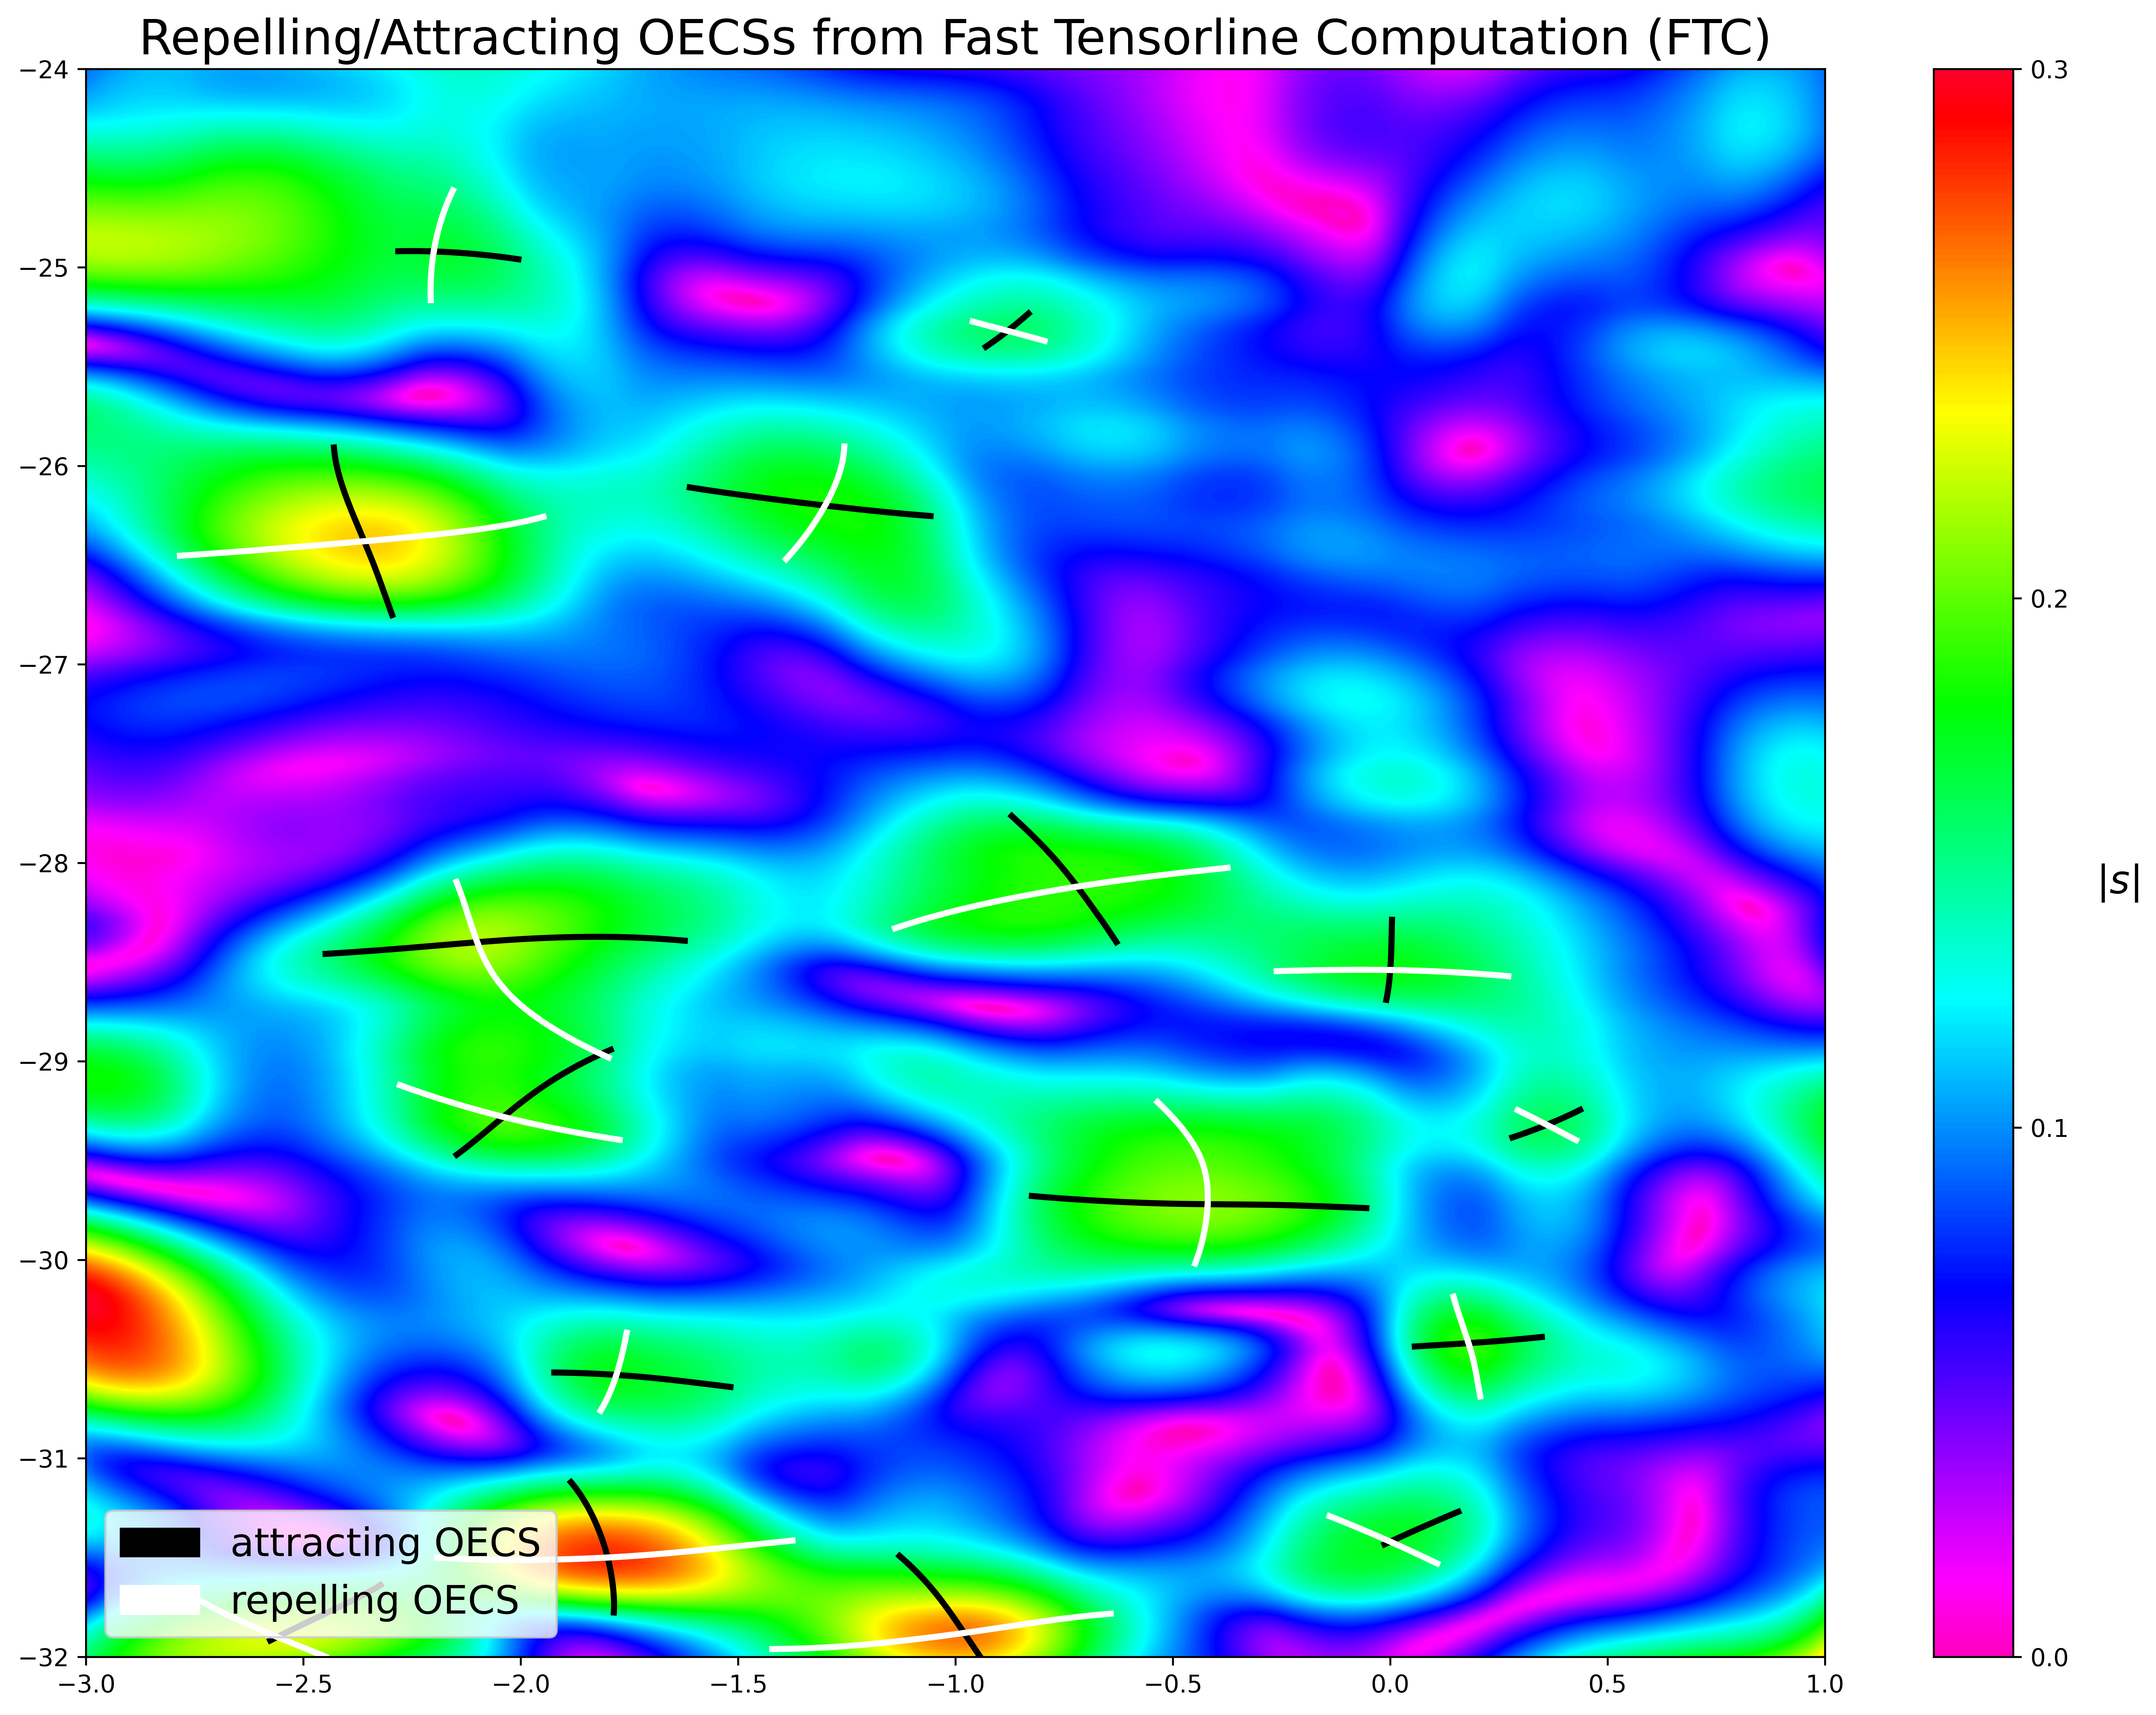

In [17]:
################################ PLOT HYPERBOLIC OECS ################################

import matplotlib.pyplot as plt

# generate figure and axis object
fig = plt.figure(figsize = (16, 12), dpi = 600)
ax = plt.axes()

# Plot |s|-field
cax = ax.contourf(X_domain, Y_domain, np.abs(s), levels = 600, cmap = "gist_rainbow_r")

cbar = plt.colorbar(cax)
cbar.set_ticks(np.arange(0, 1.5, 0.1))
cbar.set_label(r'$ |s| $', rotation = 0, labelpad = 20, fontsize = 16)

# Plot attracting OECS
for i in range(len(x_attracting)):
    ax_attracting = ax.plot(x_attracting[i], y_attracting[i], c = "k", linewidth = 2.5)

# Plot repelling OECS
for j in range(len(x_repelling)):
    ax_repelling = ax.plot(x_repelling[j], y_repelling[j], c = "w", linewidth = 2.5)

# set limits
ax.set_xlim(np.min(X_domain), np.max(X_domain))
ax.set_ylim(np.min(Y_domain), np.max(Y_domain))

# Set title
ax.set_title('Repelling/Attracting OECSs from Fast Tensorline Computation (FTC)', fontsize = 20)

# Plot legend
import matplotlib.patches as mpatches
attracting = mpatches.Patch(color='k', label='attracting OECS')
repelling = mpatches.Patch(color='w', label='repelling OECS')
plt.legend(handles=[attracting, repelling], fontsize = 16, loc = "lower left")
 
# Show plot
plt.show()

It can be verified that the attracting/repelling OECS computed using the *Fast Tensorline Computation* coincide with those computed in [HyperbolicOECS](http://localhost:8888/notebooks/TBarrier/2D/demos/AdvectiveBarriers/HyperbolicOECS/Main/HyperbolicOECS.ipynb). We note that this procedure is conceptually much easier as it does not require constantly checking the orientation of the eigenvector field and hence can be solved via an ODEsolver.

# Advect attracting OECS

Attracting/repelling OECS represent short term attractor/repellors of particles in the flow field. They act as the eulerian counterpart to hyperbolic LCS. Hyperbolic OECS act as a short-term unstable/stable manifold of a saddle point.
In order to highlight the validity of the extracted hyperbolic OECS and highlight the predictive power of attracting OECS for short time-intervals, we advected attracting OECSs up to 7 days and study their effect on nearby particles. We seed around every objective saddle a circular blob of particle which also gets advected by the flow. As shown in the below figure, the attracting OECS play a crucial role in shaping the deformation of the blobs.

In [ ]:
# Import package for computing trajectories
from ipynb.fs.defs.integration_dFdt import integration_dFdt

# efine time-horizon over which to advect
time_advect = np.linspace(t_OECS, t_OECS+7, 50, endpoint = True)

# Define figure/axes
fig = plt.figure(figsize = (16, 10), dpi = 600)
ax = plt.axes()

# Iterate over all attracting OECS and plot
for i in tqdm(range(len(objective_saddle))):
    
    x_advected, y_advected = [], []
                    
    for j in range(len(x_attracting[i])):
        
        x = np.array([x_attracting[i][j], y_attracting[i][j]])
                    
        # Advect OECS over 7 days
        Fmap = integration_dFdt(time_advect, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]

        # extract end-point of advection
        x_end = Fmap[:,-1]
                    
        x_advected.append(x_end[0])
        y_advected.append(x_end[1])
    
    ax.plot(x_advected, y_advected, linewidth = 5, c = "r")
    
    # create circle around objective saddle and seed it with particle
    r = 0.25
    x_circle, y_circle = [], []
    for phi in np.linspace(0, 2*np.pi, 100):
        x_circle.append(objective_saddle[i][0]+r*np.cos(phi))
        y_circle.append(objective_saddle[i][1]+r*np.sin(phi))
    
    x_circle_advected, y_circle_advected = [], []
    # advect particles around objective saddle over 7 days
    for t in range(len(x_circle)):
        
        x = np.array([x_circle[t], y_circle[t]])
                    
        # Advect OECS over 7 days
        Fmap = integration_dFdt(time_advect, x, X, Y, Interpolant, periodic, defined_domain, bool_unsteady, dt_data, delta)[0]

        # extract end-point of advection
        x_end = Fmap[:,-1]
                    
        x_circle_advected.append(x_end[0])
        y_circle_advected.append(x_end[1])
        
    ax.fill(x_circle_advected, y_circle_advected, c = "b")
        
# Set axis limits
#ax.set_xlim([-5, 1])
#ax.set_ylim([-32, -24])
                
# Set axis labels
ax.set_xlabel("long (deg)", fontsize = 16)
ax.set_ylabel("lat (deg)", fontsize = 16)

# Title
ax.set_title("Advected attracting OECSs", fontsize = 20)
plt.show();

  0%|          | 0/32 [00:00<?, ?it/s]